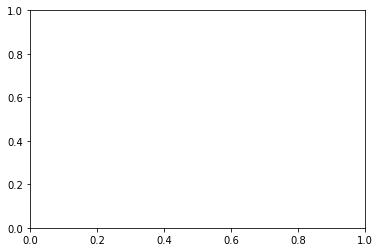

In [2]:
import sys
sys.path.insert(0, '../')

import numpy as np
from utils.Config import Config 
from registrationNN.models import NNModel, model_visualizer
from utils.ObjectUtil import ObjectUtil
from sklearn.model_selection import train_test_split
import os
from munch import Munch
import time
import random
import json 
import sys
import matplotlib.pyplot as plt
from utils.RegistrationUtils import RegistrationUtils
from animator.SketchAnimation import SketchAnimation

In [3]:
%load_ext autoreload

%autoreload 2
%matplotlib notebook

In [4]:
exp_id = 'after-decomposition-penalty'

model_config = Config.default_model_config(exp_id)
model_config.learning_rate = 5e-4
model_config.re_sampling = 120
model_config.n_files = 15
model_config.k_select = 5
model_config.epochs = 2
model_config.comment = 'no penalty on the movements'
model_config.select_only_matched = True
model_config.obj_accepted_labels = ['Triangle', 'Circle', 'Star']
model_config.redirect_out = False

model_config.load = True
model_config.load_ckpt = True
model_config.save = True
model_config.save_ckpt = True
model_config.vis_transformation = False
model_config.num_vis_samples = 5

print(f"[RegisterationMLP.py] {time.ctime()}: Expermint {model_config.exp_id} started")

org_objs, tar_objs = [], []
objs, labels = ObjectUtil.extract_objects_from_directory(model_config.dataset_path,
                                                        n_files=model_config.n_files,
                                                        acceptable_labels=model_config.obj_accepted_labels,
                                                        re_sampling = model_config.re_sampling)
labels, objs = np.asarray(labels), np.asarray(objs)

# validate that objects are distincts 
tot = 0
for obj1 in objs:
    for obj2 in objs:
        if obj1 == obj2:
            tot += 1

print(len(objs), tot)

random.seed(model_config.seed)
for obj, lbl in zip(objs, labels):
    if model_config.select_only_matched:
        matched_objs = objs[labels == lbl] # TODO test with non-matched objects
    else:
        matched_objs = objs

    # choose k random matched objects
    matched_objs = random.choices(matched_objs, k=model_config.k_select)

    for obj2 in matched_objs:
        org_objs.append(obj)
        tar_objs.append(obj2)


# split train test
train_org_sketches, val_org_sketches, train_tar_sketches, val_tar_sketches = train_test_split(org_objs, tar_objs, random_state=model_config.seed, test_size=0.2)



[RegisterationMLP.py] Sat Aug  7 01:29:18 2021: Expermint after-decomposition-penalty started
8 16


In [5]:
obj = train_org_sketches[10]

<IPython.core.display.Javascript object>


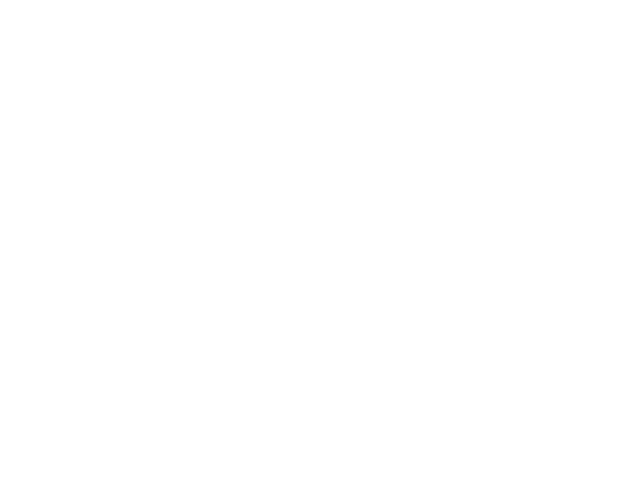

In [6]:
fig2, ax2 = plt.subplots()
obj.visualize(show=False, ax=ax2)

In [7]:
len(obj)

120

In [8]:
# scale obj1 
tmp = ObjectUtil.poly_to_accumulative_stroke3([obj], red_rdp=False)
tmp = RegistrationUtils.pad_sketches(tmp, maxlen=128)
tmp = np.expand_dims(tmp, axis=-1)
obj2 = ObjectUtil.accumalitive_stroke3_to_poly(tmp)[0]
obj.visualize(show=False, ax=ax2)

In [9]:
# prepare model
model = NNModel(model_config)

[model.py] loading saved model of experiment after-decomposition-penalty


In [281]:
c = 10
org_obj, tar_obj = train_org_sketches[c].get_copy(), train_tar_sketches[c].get_copy()

<IPython.core.display.Javascript object>


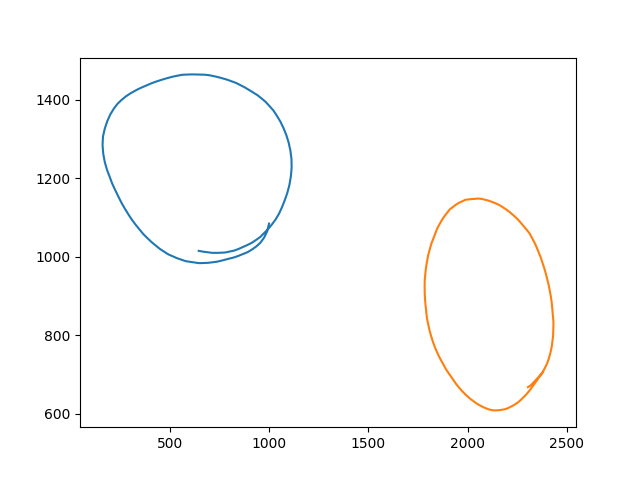

In [282]:
fig2, ax2 = plt.subplots()
org_obj.visualize(show=False, ax=ax2)
tar_obj.visualize(show=False, ax=ax2)

In [284]:
len(org_obj), len(tar_obj)

(120, 120)

In [285]:
params, losses = model.predict([org_obj], [tar_obj])

In [286]:
params, losses

(array([[ 0.6164669 , -1.3186553 ,  1.5930966 ,  0.06658266,  0.01791772,
         -2.6899564 ,  1.3900946 ]], dtype=float32),
 array([15.272812]))

In [287]:
RegistrationUtils.obtain_transformation_matrix(params[0])

array([-0.02478918,  1.31832731, -2.68995643,  0.61606729,  0.02940395,
        1.39009464])

<IPython.core.display.Javascript object>


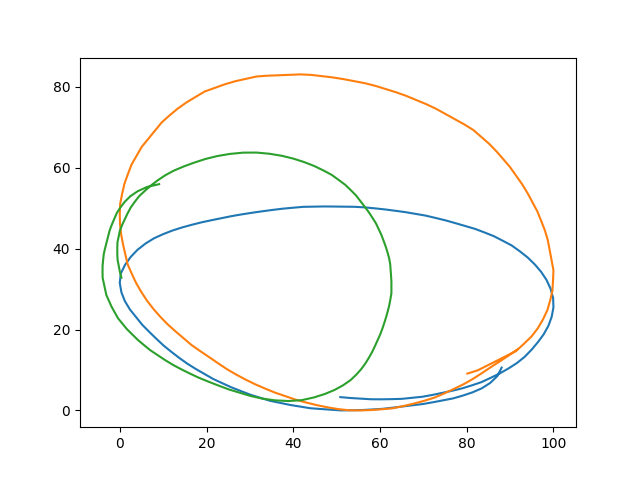

In [288]:
# scale obj1 
tmp = ObjectUtil.poly_to_accumulative_stroke3([org_obj])
tmp = RegistrationUtils.pad_sketches(tmp, maxlen=128)
tmp = np.expand_dims(tmp, axis=-1)
obj1_2 = ObjectUtil.accumalitive_stroke3_to_poly(tmp)[0]

# scale obj2
tmp = ObjectUtil.poly_to_accumulative_stroke3([tar_obj])
tmp = RegistrationUtils.pad_sketches(tmp, maxlen=128)
tmp = np.expand_dims(tmp, axis=-1)
obj2_2 = ObjectUtil.accumalitive_stroke3_to_poly(tmp)[0]

fig2, ax2 = plt.subplots()
obj1_2.visualize(show=False, ax=ax2)
obj2_2.visualize(show=False, ax=ax2)

p = params[0]
t = RegistrationUtils.obtain_transformation_matrix(p)
obj1_2.transform(t, object_min_origin=False)
obj1_2.visualize(show=False, ax=ax2)

0.6813139072710953


<IPython.core.display.Javascript object>


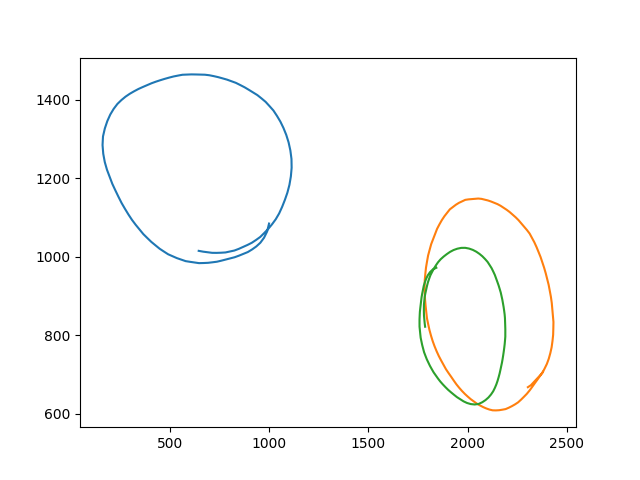

In [292]:
t = RegistrationUtils.obtain_transformation_matrix(params[0])
t_denormalized = ObjectUtil.denormalized_transformation(org_obj, tar_obj, t)

fig2, ax2 = plt.subplots()
org_obj.visualize(show=False, ax=ax2)
tar_obj.visualize(show=False, ax=ax2)
# obj2.transform(t_denormalized)
# obj2.visualize(show=False, ax=ax2)

In [296]:
tmp_obj = org_obj.get_copy()
tmp_obj.transform(t_denormalized, object_min_origin=True)
tmp_obj.visualize(show=False, ax=ax2)

In [297]:
# test sequential 

<IPython.core.display.Javascript object>


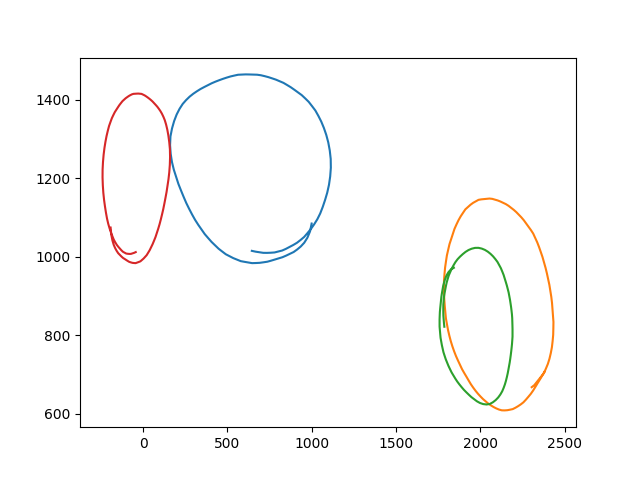

In [295]:
p_decomposed = RegistrationUtils.decompose_tranformation_matrix(t)

obj1_seq = org_obj.get_copy()

p_denormalized = RegistrationUtils.decompose_tranformation_matrix(t_denormalized)

seq_params = RegistrationUtils.get_seq_translation_matrices(p_denormalized)

fig2, ax2 = plt.subplots()
obj1_seq.visualize(show=False, ax=ax2)
tar_obj.visualize(show=False, ax=ax2)
# obj2.transform(t_denormalized)
# obj2.visualize(show=False, ax=ax2)




In [298]:
i = 0
t1 = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]

In [299]:
tp = np.zeros(6)
t = seq_params[i]
tp = np.zeros(6)
print(t)
tp[0] = t[0] * t1[0] + t[1] * t1[3]
tp[1] = t[0] * t1[1] + t[1] * t1[4]
tp[2] = t[2] + t1[2]
tp[3] = t[3] * t1[0] + t[4] * t1[3]
tp[4] = t[3] * t1[1] + t[4] * t1[4]
tp[5] = t[5] + t1[5]
t1 = tp
if i == 4:
    obj1_seq.transform(t, object_min_origin=True, retain_origin=False)
else:
    obj1_seq.transform(t, object_min_origin=True, retain_origin=True)
obj1_seq.visualize(show=False, ax=ax2)
i += 1

[-0.42000745237595194, 0.0, 0.0, 0.0, 0.8984181127538624, 0.0]


In [300]:
t1, t_denormalized, RegistrationUtils.obtain_transformation_matrix(p_denormalized) #should all be equal

(array([-0.42000745,  0.        ,  0.        ,  0.        ,  0.89841811,
         0.        ]),
 array([-1.68892135e-02,  8.98194729e-01,  1.76586661e+03,  4.19735213e-01,
         2.00333220e-02,  6.18028064e+02]),
 array([-1.68892135e-02,  8.98194729e-01,  1.76586661e+03,  4.19735213e-01,
         2.00333220e-02,  6.18028064e+02]))

# animate transformation

<IPython.core.display.Javascript object>


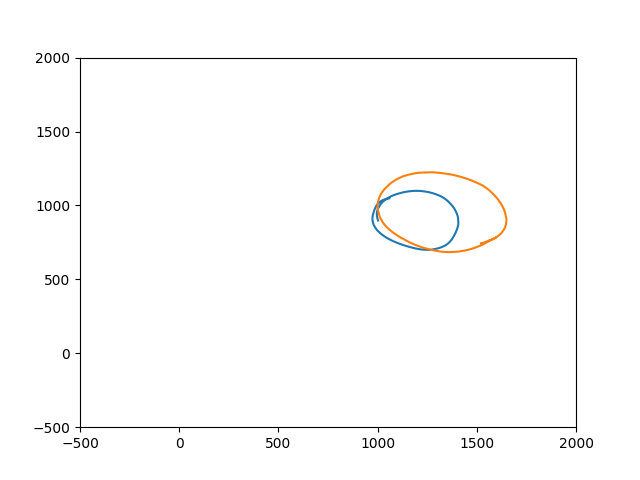

Before [ 0.6164669  -1.3186553   1.5930966   0.06658266  0.01791772 -2.6899564
  1.3900946 ]
0.6813139072710953
After [-4.20007452e-01  8.98418113e-01 -1.54849604e+00  0.00000000e+00
  1.79177151e-02  9.82529896e+02  6.93600177e+02]
Seq Params: [[[-0.42000745237595194, 0.0, 0.0, 0.0, 0.8984181127538624, 0.0], [1.0, 0.0, 0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.017917715057904692, 1.0, 0.0], [0.022298439604735022, 0.9997513588843948, 0.0, -0.9997513588843948, 0.022298439604735022, 0.0], [1.0, 0.0, 982.5298961476709, 0.0, 1.0, 693.6001771655157]]]
1 1000


In [308]:
obj1_seq = org_obj.get_copy()
pre_org = obj1_seq.get_copy()
pre_tar = tar_obj.get_copy()
animation = SketchAnimation([obj1_seq], [tar_obj.get_copy()]) 
animation.seq_animate_all([params[0]], 
                         denormalize_trans=True,
                         save=False) 

In [278]:
pre_org == org_obj

True

In [279]:
pre_tar == tar_obj

False

In [277]:
org_obj.get_x()

[999.0,
 989.4186667411399,
 973.7562826869724,
 955.1450739043989,
 934.6845353902512,
 913.5011013719775,
 891.9587080198952,
 869.8733613217433,
 847.7880146235916,
 825.6240047144291,
 803.2627786014724,
 780.9015524885157,
 758.5403263755591,
 736.1549029308308,
 713.652065667553,
 691.1438470467804,
 668.598531525285,
 646.0579987533879,
 623.5680712970095,
 601.078143840631,
 578.6053392371374,
 556.3881814282665,
 534.1710236193956,
 512.1558118672833,
 490.1421667184246,
 468.716568882973,
 447.323151234108,
 426.48367756501966,
 405.6620057734013,
 385.3892068681654,
 365.21557852957307,
 346.01013652291994,
 326.80469451626675,
 308.1037128723028,
 290.20737974321474,
 272.828499948976,
 255.8282467228422,
 239.88253467820698,
 224.3063019069433,
 209.01064997494223,
 195.47903552340455,
 181.94865018227304,
 170.8634792100665,
 163.19745644421528,
 159.61559864096367,
 161.86329330826499,
 171.17120105730046,
 183.68004673018146,
 198.58959381762637,
 215.80797336020927,
 2

In [255]:
pre_org.get_x()

[1921.7037817506134,
 1894.2259280509961,
 1872.087203778479,
 1854.3166679865408,
 1840.8885662420412,
 1829.9194201472114,
 1820.3228753410558,
 1813.485590561055,
 1806.6483057810542,
 1800.440242590793,
 1795.8096981882777,
 1791.1791537857625,
 1786.5486093832474,
 1782.2516593620155,
 1779.5734245992635,
 1777.0622274995985,
 1775.7025204487577,
 1774.5929187631014,
 1776.1296318506418,
 1777.6663449381824,
 1779.390928300124,
 1783.9204433973791,
 1788.4499584946343,
 1794.3632150290987,
 1800.287205983796,
 1809.0960888332636,
 1818.062843944605,
 1829.0496743681656,
 1840.0956728695267,
 1852.8041039850552,
 1865.759273454423,
 1881.1233098874266,
 1896.4873463204297,
 1912.856545651793,
 1930.8290480237795,
 1949.6819042606442,
 1969.1443826660159,
 1990.1818912011329,
 2011.7101796755483,
 2033.611164149947,
 2057.5505838129798,
 2081.4914237757116,
 2107.5849203737384,
 2135.74408002612,
 2165.560690401916,
 2195.3806842759186,
 2223.191169614561,
 2248.9140019559304,
 2271

<IPython.core.display.Javascript object>


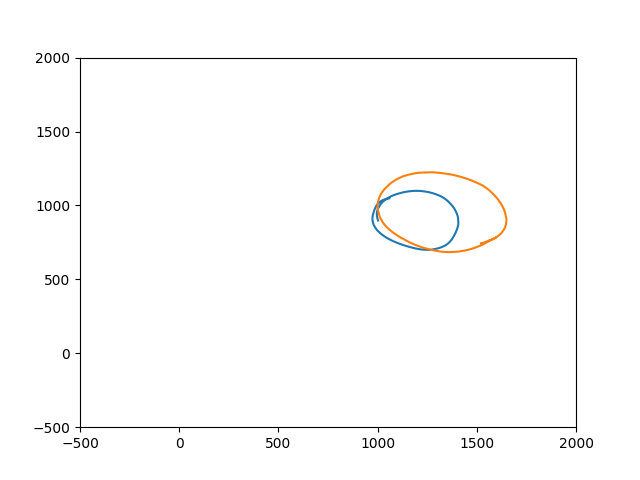

Before [ 0.6164669  -1.3186553   1.5930966   0.06658266  0.01791772 -2.6899564
  1.3900946 ]
0.6813139072710953
After [-4.20007452e-01  8.98418113e-01 -1.54849604e+00  0.00000000e+00
  1.79177151e-02  9.82529896e+02  6.93600177e+02]
Seq Params: [[[-0.42000745237595194, 0.0, 0.0, 0.0, 0.8984181127538624, 0.0], [1.0, 0.0, 0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.017917715057904692, 1.0, 0.0], [0.022298439604735022, 0.9997513588843948, 0.0, -0.9997513588843948, 0.022298439604735022, 0.0], [1.0, 0.0, 982.5298961476709, 0.0, 1.0, 693.6001771655157]]]
1 1000


In [306]:
obj1_seq = org_obj.get_copy()
animation = SketchAnimation([obj1_seq], [tar_obj]) 
animation.seq_animate_all([params[0]], 
                         denormalize_trans=True,
                         save=False) 

In [305]:
p_denormalized

array([-4.20007452e-01,  8.98418113e-01, -1.54849604e+00,  0.00000000e+00,
        1.79177151e-02,  1.76586661e+03,  6.18028064e+02])